In [1]:
import netket as nk
import json
from qutip import *
import numpy as np
import time
import multiprocessing as mp
from collections import OrderedDict
from pickle import dump
import os
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from functools import reduce
plt.style.use('seaborn')
from scipy.stats import norm

In [2]:
# Central Spin Hamiltonian and Hilbert space, inputs are Hamiltonian parameters
def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define pauli matrices
    pauliz = 0.5 * np.array([[1, 0], [0, -1]])
    paulix = 0.5 * np.array([[0, 1], [1, 0]])
    pauliy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * pauliz).tolist())
    sites.append([0])
    # Interaction term
    itOp = np.kron(pauliz, pauliz) + np.kron(paulix, paulix) + np.kron(pauliy, pauliy)
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i + 1)])
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    return hamiltonian, hilbertSpace


def exactDiagonalization(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

In [3]:
gap_N = []

for i in range(7):  #here put N-1 (maximum)
    N = i+2
    # Hamiltonian Parameters
    B = 0.95
    alpha = 1
    # B = N/2
    A = N/2
    N0 = N / 2
    M = alpha * N
    # List of Ak
    Ak = []
    for i in range(N - 1):
        Ak_i = A / (N0) * np.exp(-i / N0)
        #Ak_i = 1
        Ak.append(Ak_i)
    # Define hamiltonian and hilbert space
    ha, hi = CSHam(N, B, Ak)

    # Exact Diagonalization
    e, v = exactDiagonalization(ha)
    # get the gap
    gap = np.abs(e[0]-e[1])
    gap_N.append(gap)
print(gap_N)

[0.714655711206686, 0.18151865199806494, 0.12612412420872188, 0.1017429438325903, 0.0875371119095103, 0.07790872448001829, 0.07074383837386922]


In [4]:
gap_N = [0.714655711206686, 0.18151865199806494, 0.12612412420872188, 0.1017429438325903, 0.0875371119095103, 0.07790872448001829, 0.07074383837386922]
#take half of the energy gap
half_gap = []
for i in gap_N:
    half_gap.append(i/2)

#define a function that counts the number of runs with small enough energy errors
def count(eng_er_list, half_gap):
    count = 0
    for i in eng_er_list:
        if i <= half_gap:
            count += 1
    return count


#load energy error data
eng_con = []
eng_count = []
for i in range(2,9,1):
    with open('2021_summer_data/partial/var_'+'N'+str(i)+'M'+str(i)+'.json') as f:
        for line in f:
            eng_con.append(json.loads(line))
    eng_count_temp = count(eng_con[3*(i-2)], half_gap[i-2])
    eng_count.append(eng_count_temp)
print(eng_count)

[50, 46, 50, 43, 46, 41, 46]


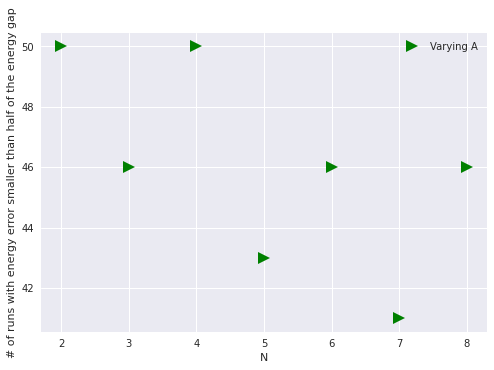

In [5]:
N = [2,3,4,5,6,7,8]
#plot the count
plt.plot(N,eng_count,'g>',markersize=12,label='Varying A')
plt.ylabel('# of runs with energy error smaller than half of the energy gap')
plt.xlabel('N')
plt.legend()
plt.show()